# Spectrogram

+ ###### Author: Dirk Van Compernolle   
+ ###### Modification History: 20/12/2023
+ ###### Requires:  pyspch>=0.8

This notebook contains a collection of spectrogram examples.

In [2]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

# Do the imports #
##################
#
%matplotlib qt
import os,sys 
import numpy as np
import pandas as pd
from IPython.display import display, Audio, HTML
import matplotlib.pyplot as plt
#   
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
SAVE_FIG = False

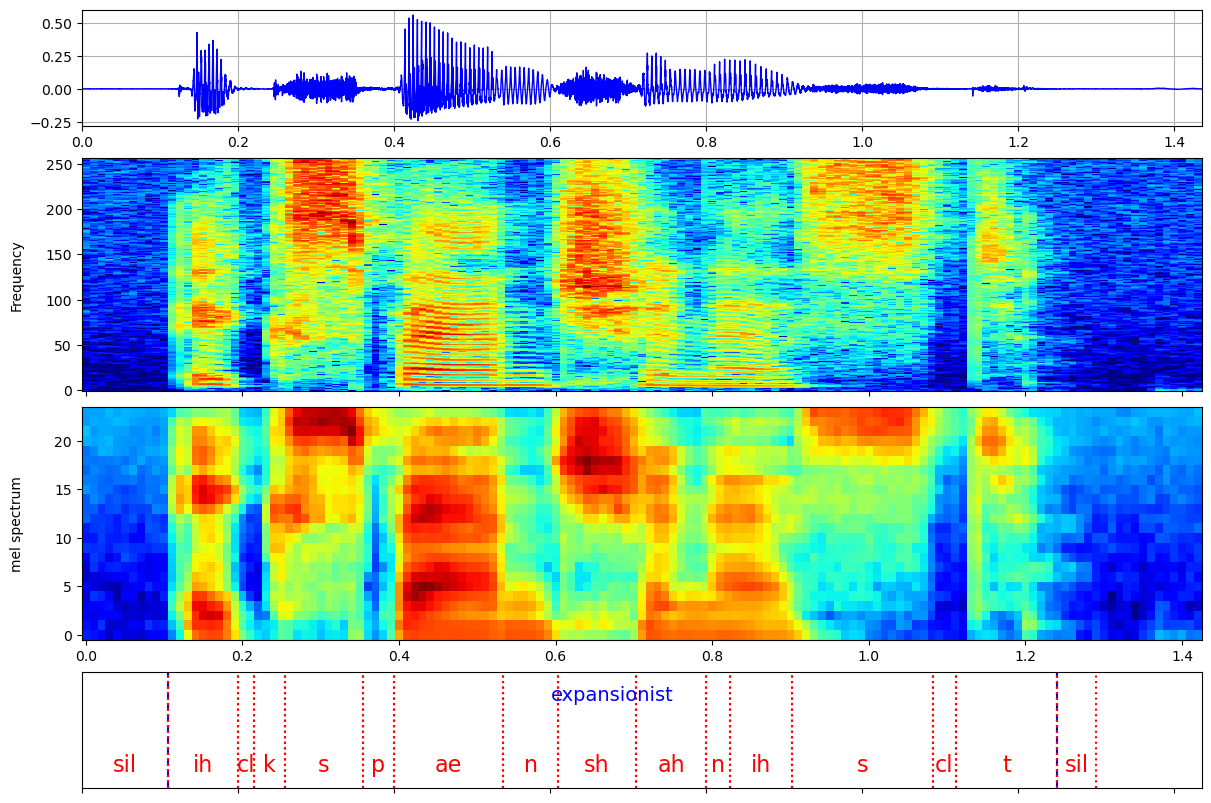

In [11]:
def Plot1(wavdata,sr,spg1,spg2,seg1,seg2,shift=0.01,lbl1='Frequency',lbl2='mel spectrum',title=None):   
    fig = Spd.SpchFig(figsize=(12,8),row_heights=[1.,2.,2.,1.],dpi=100)
    fig.add_line_plot(wavdata,iax=0,dx=1./sr)
    fig.add_img_plot(spg1,iax=1,dx=shift,xticks=False)
    fig.add_img_plot(spg2,iax=2,dx=shift)
    fig.add_seg_plot(seg1,iax=3,xrange=fig.axes[0].get_xlim(),ypos=0.8,
                     txtargs={'color':'blue','fontsize':14},lineargs={'color':'blue'}) 
    fig.add_seg_plot(seg2,iax=3,ypos=0.2,lineargs={'linestyles':'dotted'})
    fig.suptitle(title,fontsize=16);
    ax=fig.axes
    ax[1].set_ylabel(lbl1)
    ax[2].set_ylabel(lbl2)
    fig.align_ylabels(ax[:])
    return fig
    
fig = Plot1(wavdata,sr,spg,melspg1,segwrd,segphn)

display(fig)
display(Audio(data=wavdata,rate=sr))

## 1.  Waveform + Spectrogram with segmentations

First we load a sample waveform with its available segmentations.  
Two example files are suggested:   
- "friendly":  i.e. "friendly computers" spoken by a male voice in a narrowband recording (8kHz sampling rate, 4kHz bandwidth)
- "expansionist": i.e. "expansionist" spoke by a female voice in a wideband recording (16kHz sampling rate, 8kHz bandwidth)   

Then we create a standard spectrogram view of the loaded speech file.
In the top pane we see the sample time waveform and below it a spectrogram.  The waveform shows the signal amplitude at every sample.  The spectrogram is a heatmap representing energy in the time-frequency domain.  In practice we compute a short-time Fourier spectrum every 10msec and collect with a sliding window approach the full spectrogram.  Here we used default settings, i.e. one spectrum every 10 msec (= frame shift) and to avoid boundary effects in the Fourier computations we use a window length of 25msec over which we lay a window that tapers to zero at the edges. 

In [5]:
dir='https://homes.esat.kuleuven.be/~spchlab/data/demo/'
file = "friendly"   # narrowband, male
file = "expansionist"  # wideband, female
wavdata, sr = Spch.audio.load(dir+file+".wav")
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
segwrd = Spch.timit.read_seg_file(dir+file+ ".wrd",fmt='float32')
segphn = Spch.timit.read_seg_file(dir+file+ ".phn",fmt='float32')
seggra = Spch.timit.read_seg_file(dir+file+ ".gra",fmt='float32')
if seggra is None: seggra = segphn

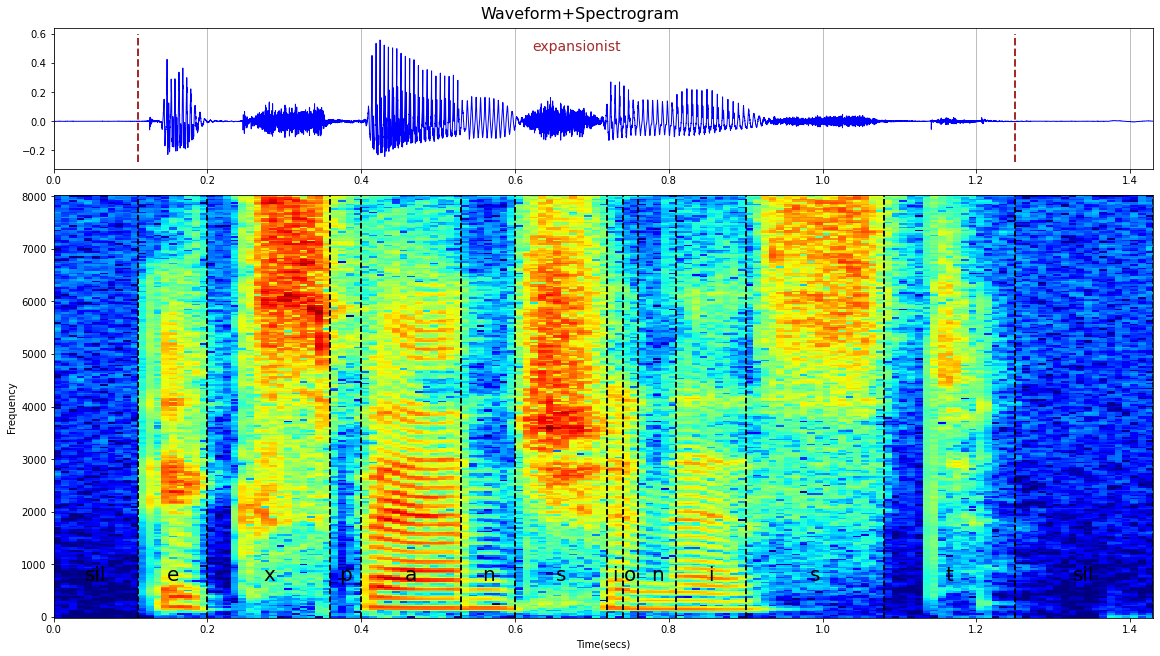

In [7]:
fig=Spd.PlotSpg(spgdata=spg,wavdata=wavdata,sample_rate=sr,ylabel='Frequency',figsize=(16,9))
fig.add_seg_plot(segwrd,iax=0,xrange=fig.axes[0].get_xlim(),ypos=0.9,
                 txtargs={'color':'brown','fontsize':14},lineargs={'color':'brown','linewidth':2}) 
fig.add_seg_plot(seggra,iax=1,ypos=0.1,txtargs={'color':'black','fontsize':20},
                 lineargs={'color':'black','linestyles':'dashed'})
fig.suptitle("Waveform+Spectrogram",fontsize=16);
fig.axes[0].grid(False,axis='y')
display(fig)
display(Audio(data=wavdata,rate=sr))
if SAVE_FIG : fig.savefig("figures/spg_"+file+".png")

## 2. Critical Band and High Resolution mel spectrograms

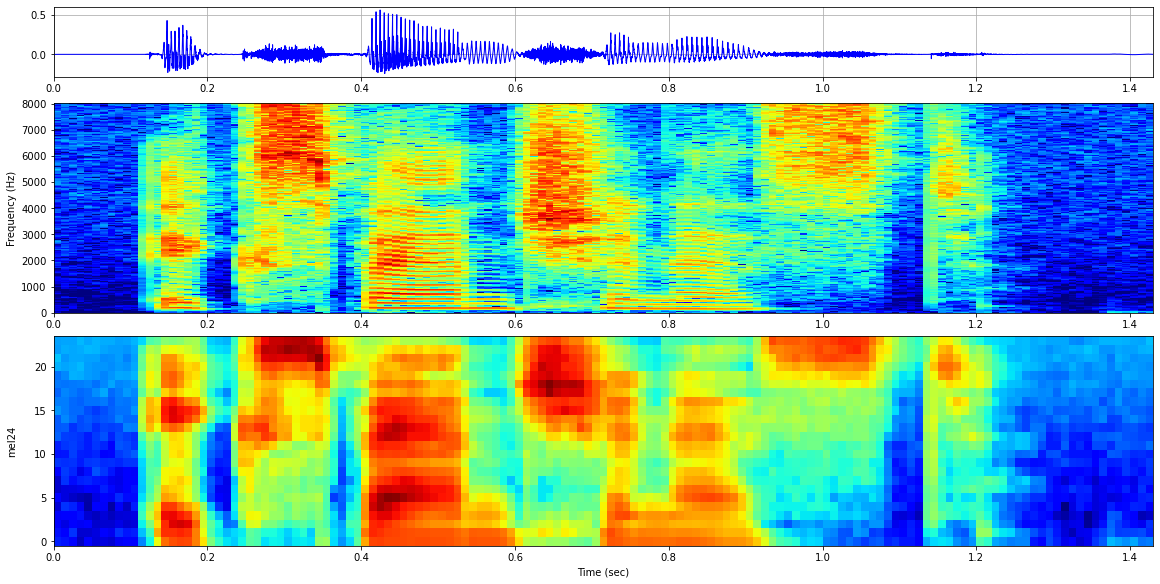

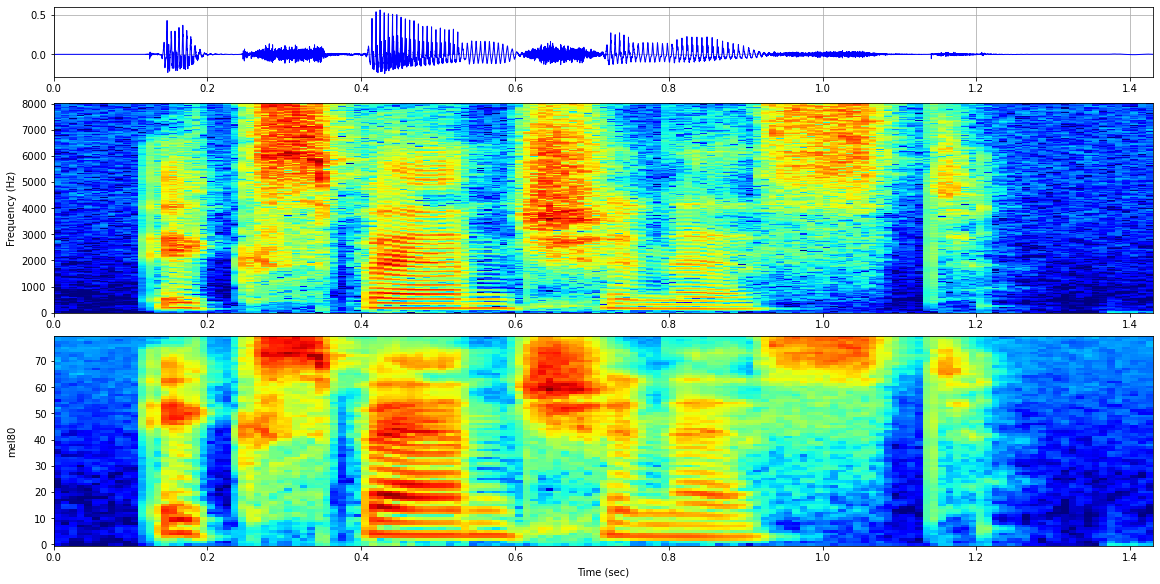

In [8]:
if sr == 8000:
    n_mels1 = 20
    n_mels2 = 64
else:
    n_mels1 = 24
    n_mels2 = 80
lbl1 = 'mel'+str(n_mels1)
lbl2 = 'mel'+str(n_mels2)
melspg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mels1)
melspg2 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mels2)

fig1 = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg1],img_labels=[lbl1],sample_rate=sr,figsize=(16,8))
display(fig1)
fig2 = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg2],img_labels=[lbl2],sample_rate=sr,figsize=(16,8))
display(fig2)
if SAVE_FIG : 
    fig1.savefig("figures/melspg1_"+file+".png")
    fig2.savefig("figures/melspg2_"+file+".png")

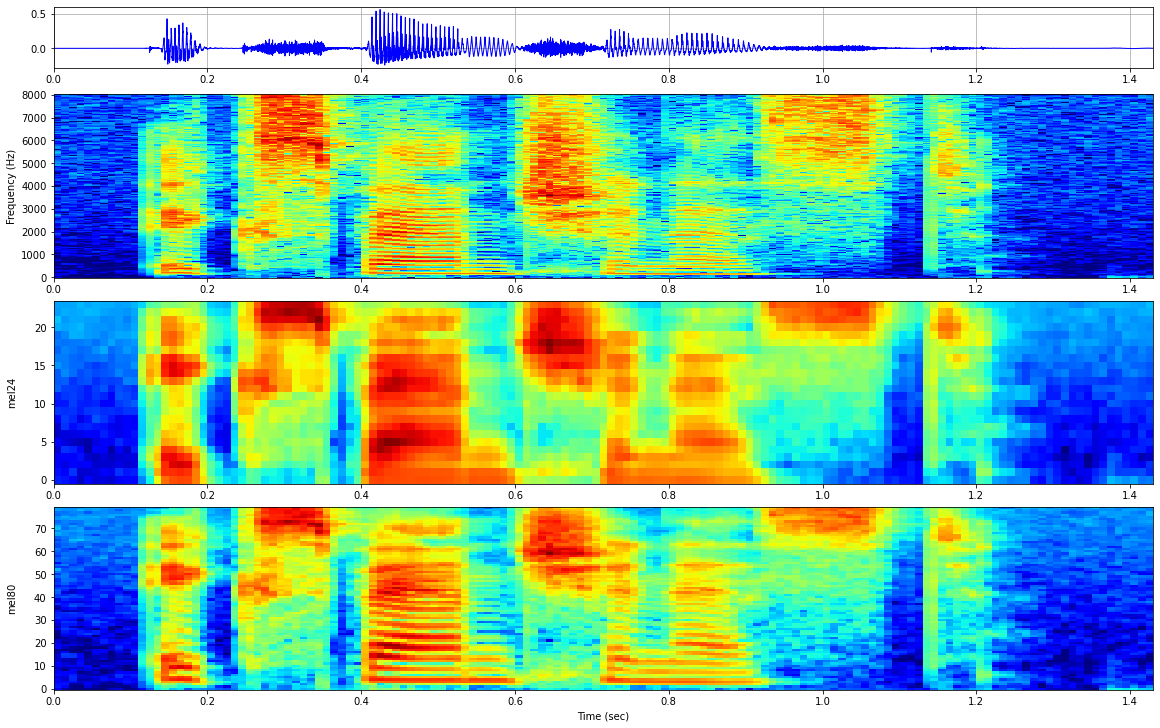

In [9]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[melspg1,melspg2],img_labels=[lbl1,lbl2],sample_rate=sr,figsize=(16,10))
display(fig)